In [1]:
import sys, os, time
import numpy as np
import pandas as pd 
sys.path.append('../src')
from vehicle_transforms import tf_skid_steering
from vehicle_simulator import sim_skid_steering
from spline_controller import spline_controller
from vehicle_controller import vehicle_controller
from heading_rate_controller import PID_hdg
import geometry
import matplotlib.pyplot as plt

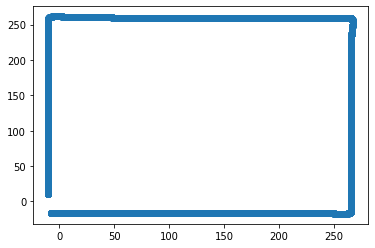

In [2]:
kp = 2.0
ki = 0
kd = 1.0
acc = 1.0
tf_veh = tf_skid_steering( 0.5, 0.254 )
sim_veh = sim_skid_steering( 0.5, 0.254, 10, -10, 0, 0, acc)
hc = PID_hdg( kp, ki, kd )
targ_velocity = 3.5
N = 10000
time_space = np.linspace(0, 40, num=N)

for i in range(N) :
    if time_space[i] < 10 :
        targ_heading = 0
    elif time_space[i] <20 :
        targ_heading = np.pi/2
    elif time_space[i] < 30 :
        targ_heading = np.pi
    else :
        targ_heading = 3 * np.pi / 2
    
    if i == 0 :
        (rov_x, rov_y, rov_theta) = sim_veh.step(0,0,time_space[i])
    else:
        (rov_x, rov_y, rov_theta) = sim_veh.step(rvel,lvel,time_space[i])
    
    hdg_rate = hc.step(targ_heading, rov_theta, time_space[i])
    (rvel, lvel) = tf_veh.transform( hdg_rate, targ_velocity)

plt.scatter(sim_veh.y, sim_veh.x)
    
pd.DataFrame({'x':sim_veh.x, 'y':sim_veh.y}).to_csv('sim_tuning.csv')



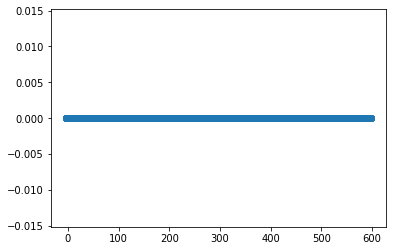

In [3]:
time_space = np.linspace(0,120,num=N)
x_path = 0*np.ones(time_space.shape)
y_path = 5*time_space-3
plt.scatter(y_path, x_path)

In [4]:
def targ_hdg_fnc( rov_x, rov_y, rov_heading, cp_x, cp_y, cp_hdg ) :
    """This is the error function which produces a heading rate"""
    hdg_error = geometry.angle_min_diff( rov_heading, cp_hdg )
    brg = geometry.bearing((rov_x, rov_y),(cp_x, cp_y))
    dist = np.sign(geometry.angle_min_diff( cp_hdg, brg )) * geometry.distance((cp_x, cp_y), (rov_x, rov_y))
    err = (np.math.atan(dist)+ hdg_error) / (3 * np.pi /2)
    #print(hdg_error, dist, err)
    targ_hdg = rov_heading + err
    return targ_hdg

In [5]:
tf_veh = tf_skid_steering( 0.5, 0.254 )
sim_veh = sim_skid_steering( 0.5, 0.254, 10, 10, 0*np.pi/2, 0, acc)
sc = spline_controller( targ_hdg_fnc, 'xyz', 'xyz', 4.0, 0.5, 0.5, 1.0, 5.0, 10,10000)
hc = PID_hdg( kp , ki, kd)
vc = vehicle_controller( sc, hc, tf_veh )

In [6]:
for idx in range( len( time_space ) ) :
    vc.src_add(x_path[idx], y_path[idx], time_space[idx])

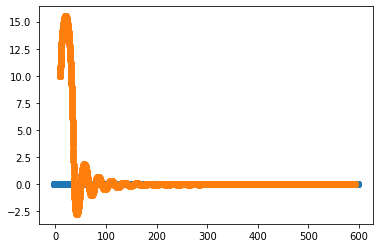

In [7]:
for idx in range( len( time_space ) ) :
    if idx == 0 or halt :
        (rov_x, rov_y, rov_theta) = sim_veh.step(0,0,0)
    else :
        (rov_x, rov_y, rov_theta) = sim_veh.step(rvel, lvel, time_space[idx])
    
    ((rvel, lvel), lateness, halt) = vc.controller_step( time_space[idx], rov_x, rov_y, rov_theta)
    if halt:
        break

time_delta = 0.1
last_time = time_space[-1]
"""
i =0
while (rvel > 0 and lvel > 0) and i < 1000 :
    last_time += time_delta
    (rov_x, rov_y, rov_theta) = sim_veh.step(rvel, lvel, last_time)
    ((rvel,lvel),lateness) = vc.controller_step( last_time, rov_x, rov_y, rov_theta)
    i += 1
"""
plt.scatter(y_path, x_path)
plt.scatter(sim_veh.y, sim_veh.x)
#print(vc.sc.src_data.get_whole_array()[:,vc.sc.idx_heading])
pd.DataFrame({'src_x':x_path, 'src_y':y_path}).to_csv('src_straight_line.csv')
pd.DataFrame({'rov_x':sim_veh.x, 'rov_y':sim_veh.y}).to_csv('rov_straight_line.csv')

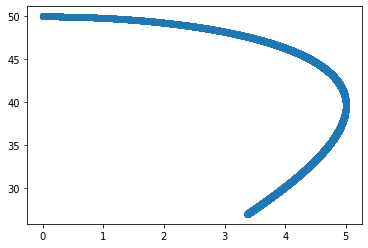

In [8]:
time_space = np.linspace(0,120,num=N)
x_path = 50*np.cos(time_space/120)
y_path = 5*np.sin(time_space/50)
plt.scatter(y_path, x_path)

In [9]:
tf_veh = tf_skid_steering( 0.5, 0.254 )
sim_veh = sim_skid_steering( 0.5, 0.254, 45, -10, -np.pi/2, 0, acc)
sc = spline_controller( targ_hdg_fnc, 'xyz', 'xyz', 4.0, 0.5, 0.5, 1.0, 5.0, 10,10000)
hc = PID_hdg( kp , ki, kd)
vc = vehicle_controller( sc, hc, tf_veh )

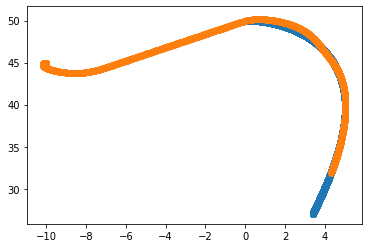

In [10]:
for idx in range( len( time_space ) ) :
    vc.src_add(x_path[idx], y_path[idx], time_space[idx])
for idx in range( len( time_space ) ) :
    if idx == 0 or halt:
        (rov_x, rov_y, rov_theta) = sim_veh.step(0,0,0)
    else :
        (rov_x, rov_y, rov_theta) = sim_veh.step(rvel, lvel, time_space[idx])
    
    ((rvel, lvel), lateness, halt) = vc.controller_step( time_space[idx], rov_x, rov_y, rov_theta)


time_delta = 0.1
last_time = time_space[-1]
"""
i =0
while (rvel > 0 and lvel > 0) and i < 1000 :
    last_time += time_delta
    (rov_x, rov_y, rov_theta) = sim_veh.step(rvel, lvel, last_time)
    ((rvel,lvel),lateness) = vc.controller_step( last_time, rov_x, rov_y, rov_theta)
    i += 1
"""
plt.scatter(y_path, x_path)
plt.scatter(sim_veh.y, sim_veh.x)
#print(vc.sc.src_data.get_whole_array()[:,vc.sc.idx_heading])
pd.DataFrame({'src_x':x_path, 'src_y':y_path}).to_csv('src_curve.csv')
pd.DataFrame({'rov_x':sim_veh.x, 'rov_y':sim_veh.y}).to_csv('rov_curve.csv')